# Part III: What can I charge for the place I have? 

Instead of browsing through AirBnb to find similar listings to my place to see what I can charge, I want to see if I can use a machine learning model to predict a price for my place. 

In [1]:
# Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import joblib
%matplotlib inline

## Step 1: Gather

I will be using the 'listings.csv' dataset 

In [2]:
#Import listings.csv 
df_listings = pd.read_csv('./listings.csv')
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


# Step 2: Assess

I want to look at the columns in my dataset that could influence how I set my price and get them ready for modelling. 

In [3]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

I need to check the completeness of my dataset. 

In [4]:
# Function to check for missing values 

def check_missing_values(df):
    
    missing = df.isnull().mean()*100
    columns_with_null = missing[missing > 0]
    
    if columns_with_null.shape[0] > 0:
        columns_with_null.plot.bar(title='Missing values per column, %')
    else:
        return "No columns with missing values"

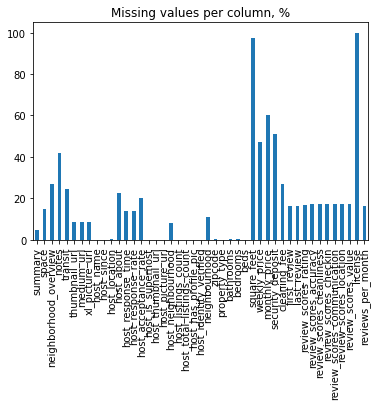

In [5]:
check_missing_values(df_listings)

I can now identify which columns I should remove from the dataset: 
- Columns which logically do not influence the price e.g. host_thumbnail_url
- Columns which I have no control over e.g. number_of_reviews
- Columns which are missing too much information e.g. license, square_feet

In [6]:
drop_cols = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'description', 'experiences_offered', 
             'neighborhood_overview', 'transit','thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 
             'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 
            'host_neighbourhood', 'street', 'space', 'notes' , 'city', 'state', 'is_location_exact', 
             'market', 'calendar_updated', 'first_review', 'last_review', 'jurisdiction_names', 'smart_location', 'country_code',
             'country', 'weekly_price', 'monthly_price', 'cleaning_fee', 'security_deposit', 'has_availability', 'review_scores_rating', 
             'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
             'review_scores_location', 'review_scores_value', 'reviews_per_month', 'neighbourhood', 'neighbourhood_cleansed', 'extra_people',
             'availability_30', 'availability_60','availability_90', 'availability_365', 'instant_bookable', 'host_verifications', 
            'number_of_reviews', 'license', 'square_feet']

df_listings.drop(columns = drop_cols, inplace=True)

# Step 3: Clean

I am interested in the *price* column which will be my response variable in my model. It needs to be cleaned up a bit.

In [7]:
#Convert price to float
df_listings['price'] = df_listings['price'].str.replace("[$, ]", "").astype("float")

/var/folders/67/jgz6df654fv9n3yp6bkjl9f8ry5zws/T/ipykernel_10964/1456755852.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_listings['price'] = df_listings['price'].str.replace("[$, ]", "").astype("float")


Now I want to clean up some columns that could be useful in the analysis. This includes:
- Converting numerical data to floats if they are not already
- Doing transformations on columns to make them more useful

In [8]:
#Columns that should be floats
df_listings['host_response_rate'] = df_listings['host_response_rate'].str.replace("%","").astype(float, errors = 'raise')
df_listings['host_acceptance_rate'] = df_listings['host_acceptance_rate'].str.replace("%","").astype(float, errors = 'raise')

It might be interesting to see if more experienced hosts charge more for their listings. I will convert the 'host_since' column into how long the host has hosted for in 'number of days'

In [9]:
#Length of time hosting
df_listings["host_since"] = pd.to_datetime(df_listings["host_since"])
df_listings["calendar_last_scraped"] = pd.to_datetime(df_listings["calendar_last_scraped"])
df_listings["host_for"] =  (df_listings["calendar_last_scraped"] - df_listings['host_since']).dt.days
df_listings.drop(columns = ['host_since', 'calendar_last_scraped'], inplace=True)
df_listings["host_for"]

0       1607.0
1       1047.0
2        571.0
3        789.0
4       1497.0
         ...  
3813     266.0
3814      82.0
3815       5.0
3816     366.0
3817     619.0
Name: host_for, Length: 3818, dtype: float64

The amenities column is a bit messy. I would like to convert the amenities list into columns to identify whether they are an important factor in determining price. 

In [10]:
df_listings["amenities"]

0       {TV,"Cable TV",Internet,"Wireless Internet","A...
1       {TV,Internet,"Wireless Internet",Kitchen,"Free...
2       {TV,"Cable TV",Internet,"Wireless Internet","A...
3       {Internet,"Wireless Internet",Kitchen,"Indoor ...
4       {TV,"Cable TV",Internet,"Wireless Internet",Ki...
                              ...                        
3813    {TV,"Cable TV",Internet,"Wireless Internet","A...
3814    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
3815    {"Cable TV","Wireless Internet",Kitchen,"Free ...
3816    {TV,"Wireless Internet",Kitchen,"Free Parking ...
3817    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, Length: 3818, dtype: object

In [11]:
#Clean amenities column
df_listings['amenities'] = df_listings['amenities'].str.replace('"', '')
df_listings['amenities'] = df_listings['amenities'].str.replace('{', '')
df_listings['amenities'] = df_listings['amenities'].str.replace('}', '')

/var/folders/67/jgz6df654fv9n3yp6bkjl9f8ry5zws/T/ipykernel_10964/1813852436.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_listings['amenities'] = df_listings['amenities'].str.replace('{', '')
/var/folders/67/jgz6df654fv9n3yp6bkjl9f8ry5zws/T/ipykernel_10964/1813852436.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_listings['amenities'] = df_listings['amenities'].str.replace('}', '')


In [12]:
#Create function to transform fields with lists into their own columns 

def is_value_in_list(value, row, column):
    if value in row[column]:
        fill = "t"
    else:
        fill = "f"
    return fill

def list_into_columns(df, col):
    
    count_rows = df.shape[0]
    new_df = df[col].value_counts().reset_index()
    new_df.rename(columns={'index': col, col: 'count'}, inplace=True)
    new_df[col] = new_df[col].str.split(",")
    new_df = new_df.explode(col).reset_index(drop=True)
    new_df = new_df.groupby([col]).sum()['count'].reset_index()
    new_df = new_df.sort_values('count', ascending=False)
    new_df['perc'] = new_df['count']/count_rows
    
    new_columns = list(new_df.head(10)['amenities'])
    
    df[col].str.split(",")
    
    for column in new_columns:
        df[col + "_" + column] = df.apply(lambda row: is_value_in_list(column, row, col), axis = 1)
    
    df.drop(columns = col, inplace =True)
    return df

In [13]:
# Create new columns for amenities
df_listings = list_into_columns(df_listings, 'amenities')
df_listings.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,zipcode,...,amenities_Wireless Internet,amenities_Heating,amenities_Kitchen,amenities_Smoke Detector,amenities_Essentials,amenities_Dryer,amenities_Washer,amenities_Internet,amenities_Shampoo,amenities_TV
0,within a few hours,96.0,100.0,f,3.0,3.0,t,t,Queen Anne,98119,...,t,t,t,f,f,t,t,t,f,t
1,within an hour,98.0,100.0,t,6.0,6.0,t,t,Queen Anne,98119,...,t,t,t,t,t,t,t,t,f,t
2,within a few hours,67.0,100.0,f,2.0,2.0,t,t,Queen Anne,98119,...,t,t,t,t,t,t,t,t,t,t
3,NaN,NaN,NaN,f,1.0,1.0,t,t,Queen Anne,98119,...,t,t,t,t,t,t,t,t,t,f
4,within an hour,100.0,NaN,f,2.0,2.0,t,t,Queen Anne,98119,...,t,t,t,t,t,f,f,t,t,t


# Step 4: Analyze

I want to see a distribution of the prices of all the current listings in the dataset

Text(0.5, 0.98, 'Price Distribution of listings')

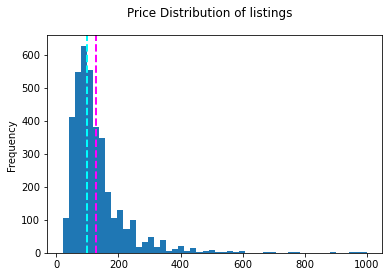

In [14]:
# Plot the histogram of prices

label = df_listings['price'] 
fig, ax = plt.subplots(1, 1)
ax.hist(label, bins=50)
ax.set_ylabel('Frequency')
ax.axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax.axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)
fig.suptitle('Price Distribution of listings')

I don't want the model to fit outliers, so I am going to remove listings with extreme prices outside 4 standard deviations from the mean. 

Text(0.5, 0.98, 'Price Distribution of listings')

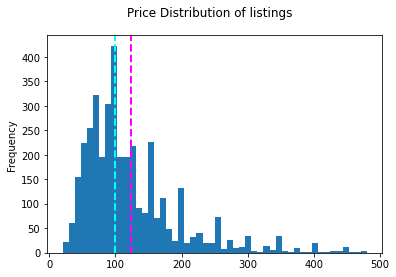

In [15]:
# Remove outliers
mean = df_listings['price'].mean()
sd = df_listings['price'].std()
df_listings = df_listings[(df_listings['price'] < mean + (4*sd))]
label = df_listings['price'] 
fig, ax = plt.subplots(1, 1)
ax.hist(label, bins=50)
ax.set_ylabel('Frequency')
ax.axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax.axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)
fig.suptitle('Price Distribution of listings')

Next I want to see the relationship between each of columns (features) and price. For numeric features, I will use scatter plots and for categorical features, I will make use of box and whisker diagrams. 

In [16]:
# Get numeric features
df_numeric_features = df_listings.select_dtypes(include=['float64', 'int64'])
df_numeric_features

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,minimum_nights,maximum_nights,calculated_host_listings_count,host_for
0,96.0,100.0,3.0,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,2,1,365,2,1607.0
1,98.0,100.0,6.0,6.0,47.639123,-122.365666,4,1.0,1.0,1.0,150.0,1,2,90,6,1047.0
3,NaN,NaN,1.0,1.0,47.638473,-122.369279,3,1.0,0.0,2.0,100.0,1,1,1125,1,789.0
4,100.0,NaN,2.0,2.0,47.632918,-122.372471,6,2.0,3.0,3.0,450.0,6,1,1125,1,1497.0
5,NaN,NaN,1.0,1.0,47.630525,-122.366174,2,1.0,1.0,1.0,120.0,1,1,6,1,1836.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,99.0,100.0,354.0,354.0,47.664295,-122.359170,6,2.0,3.0,3.0,359.0,1,3,1125,8,266.0
3814,100.0,100.0,1.0,1.0,47.649552,-122.318309,4,1.0,1.0,2.0,79.0,3,2,29,1,82.0
3815,NaN,NaN,1.0,1.0,47.508453,-122.240607,2,1.0,1.0,1.0,93.0,2,1,7,1,5.0
3816,100.0,NaN,1.0,1.0,47.632335,-122.275530,2,1.0,0.0,1.0,99.0,1,3,1125,1,366.0


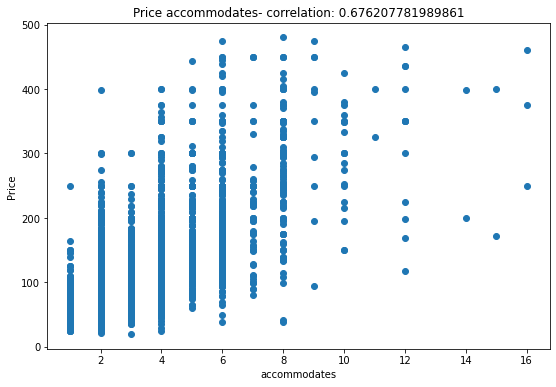

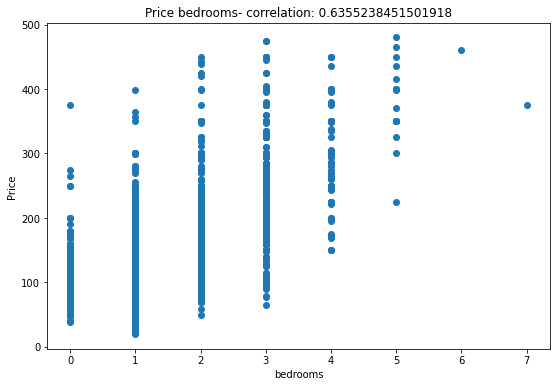

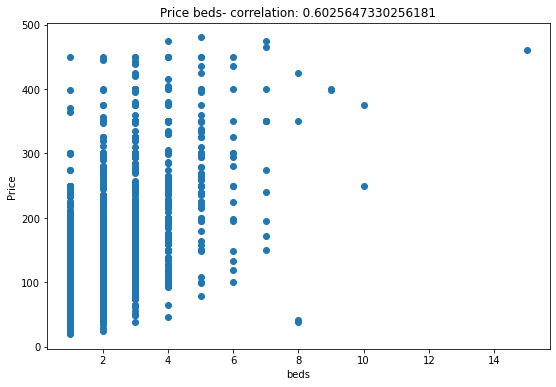

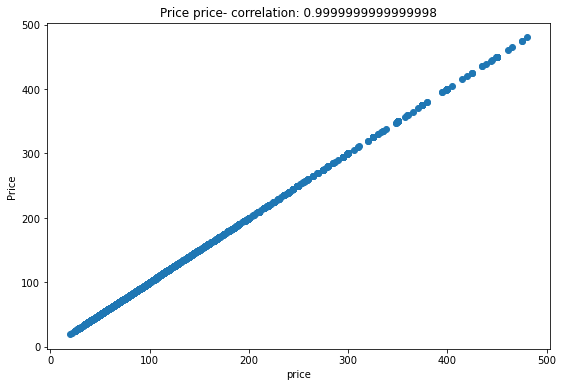

In [17]:
# View plots of numeric features where there is a correlation with price (Correlation > 0.5)

label = df_listings["price"]

for col in df_numeric_features:
    feature = df_listings[col]
    correlation = feature.corr(label)
    if correlation > 0.5:
        fig = plt.figure(figsize=(9, 6))
        ax = fig.gca()
        plt.scatter(x=feature, y=label)
        plt.xlabel(col)
        plt.ylabel("Price")
        ax.set_title('Price ' + col + '- correlation: ' + str(correlation))
plt.show()

Looking at the plots above, the columns that I would like to include in my machine learning model are as follows:

In [18]:
# Numerical columns to keep:
numerical = ['accommodates', 'bedrooms','beds', 'price']

Next, I want to look at the categorial features that could have an influence on my price. 

In [19]:
# Get categorical features
df_categorical_features = df_listings.select_dtypes(include=['object'])
df_categorical_features

,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,zipcode,property_type,room_type,bed_type,requires_license,...,amenities_Wireless Internet,amenities_Heating,amenities_Kitchen,amenities_Smoke Detector,amenities_Essentials,amenities_Dryer,amenities_Washer,amenities_Internet,amenities_Shampoo,amenities_TV
0,within a few hours,f,t,t,Queen Anne,98119,Apartment,Entire home/apt,Real Bed,f,...,t,t,t,f,f,t,t,t,f,t
1,within an hour,t,t,t,Queen Anne,98119,Apartment,Entire home/apt,Real Bed,f,...,t,t,t,t,t,t,t,t,f,t
3,NaN,f,t,t,Queen Anne,98119,Apartment,Entire home/apt,Real Bed,f,...,t,t,t,t,t,t,t,t,t,f
4,within an hour,f,t,t,Queen Anne,98119,House,Entire home/apt,Real Bed,f,...,t,t,t,t,t,f,f,t,t,t
5,NaN,f,t,t,Queen Anne,98119,House,Private room,Real Bed,f,...,t,t,f,t,t,f,f,t,t,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,within a few hours,f,t,t,Other neighborhoods,98107,House,Entire home/apt,Real Bed,f,...,t,t,t,t,t,t,t,t,t,t
3814,within an hour,f,t,t,Capitol Hill,98102,Apartment,Entire home/apt,Real Bed,f,...,t,t,t,t,t,t,f,t,t,t
3815,NaN,f,t,f,Rainier Valley,98178,House,Entire home/apt,Real Bed,f,...,t,t,t,t,t,t,t,t,f,t
3816,within an hour,f,t,t,Capitol Hill,98112,Condominium,Entire home/apt,Real Bed,f,...,t,t,t,t,t,t,f,t,f,t


/var/folders/67/jgz6df654fv9n3yp6bkjl9f8ry5zws/T/ipykernel_10964/131918113.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(9, 6))


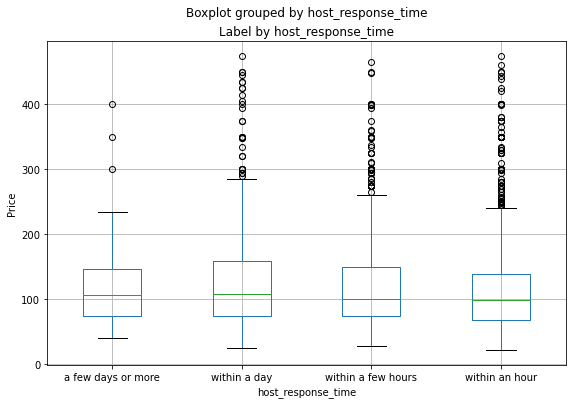

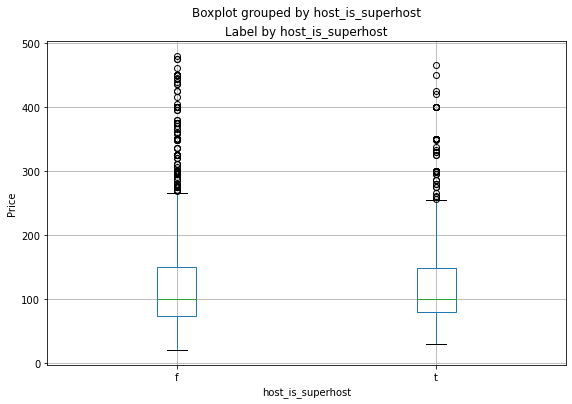

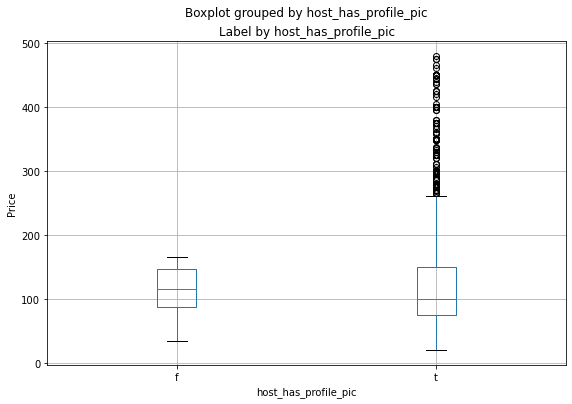

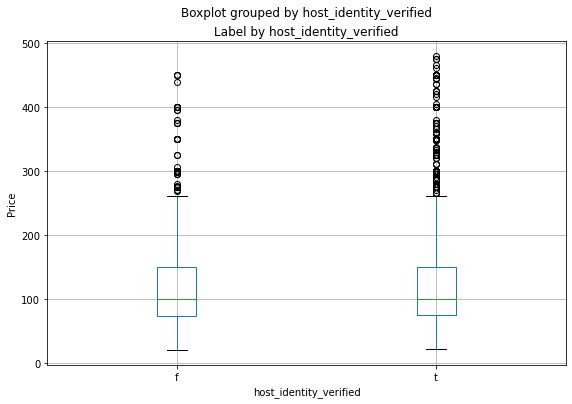

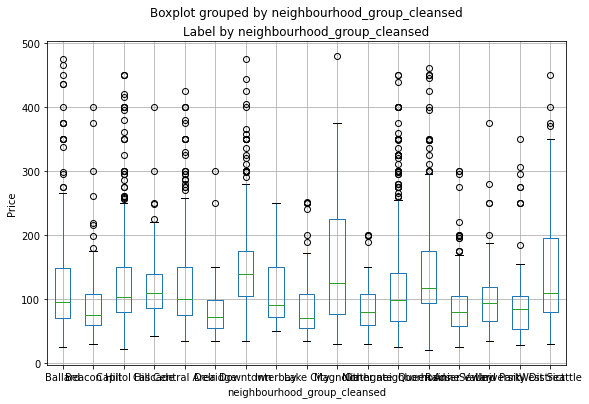

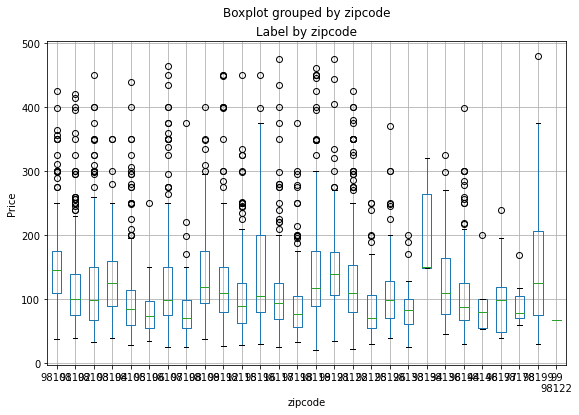

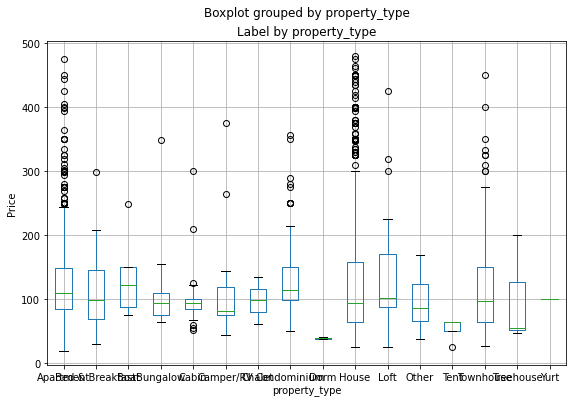

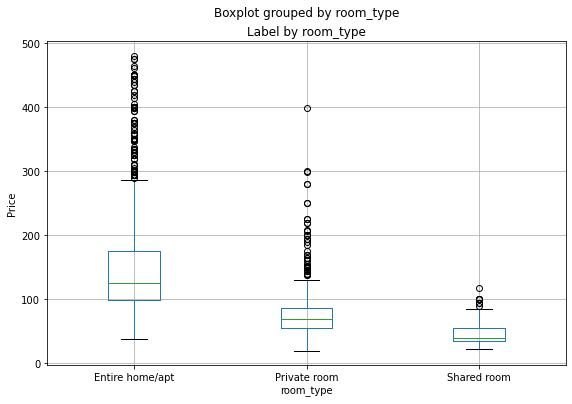

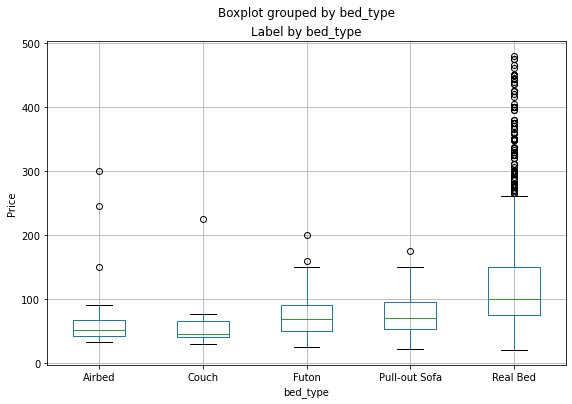

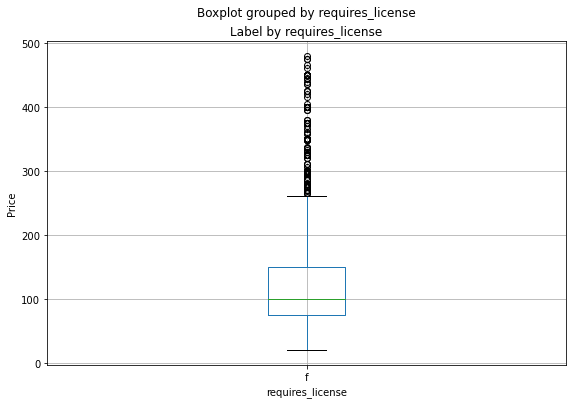

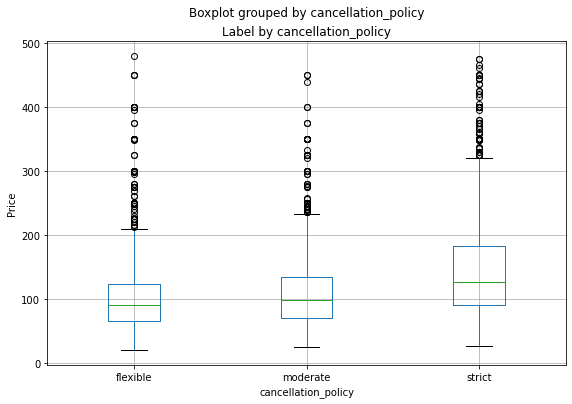

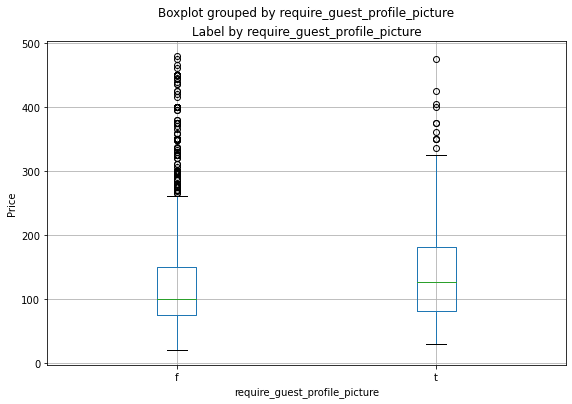

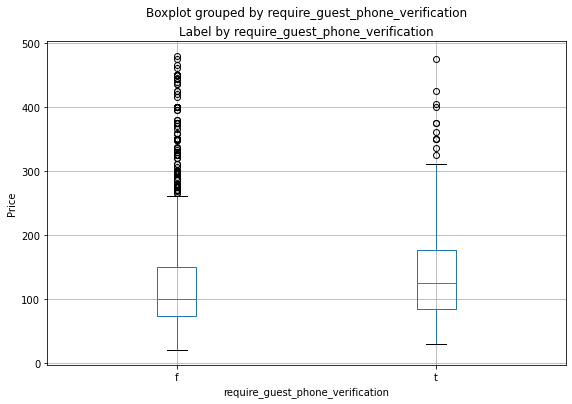

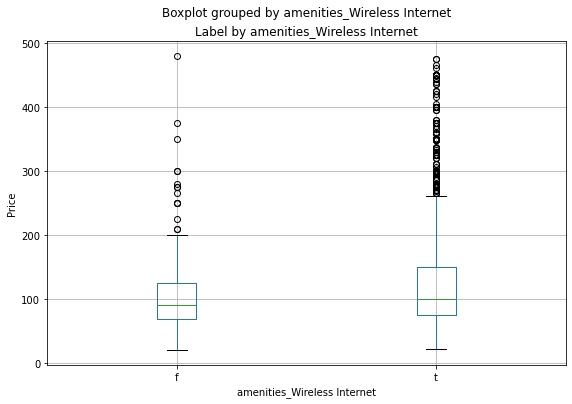

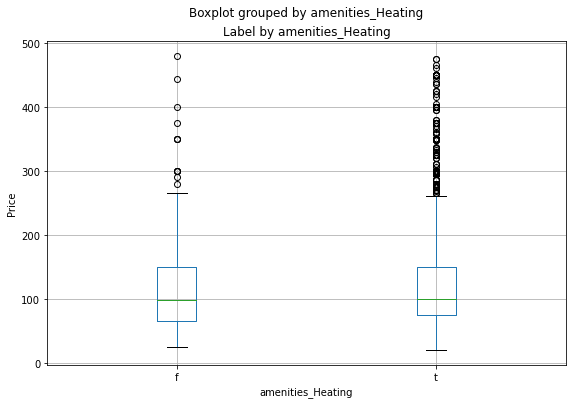

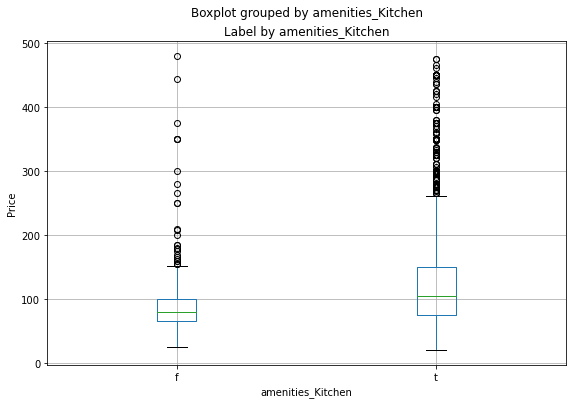

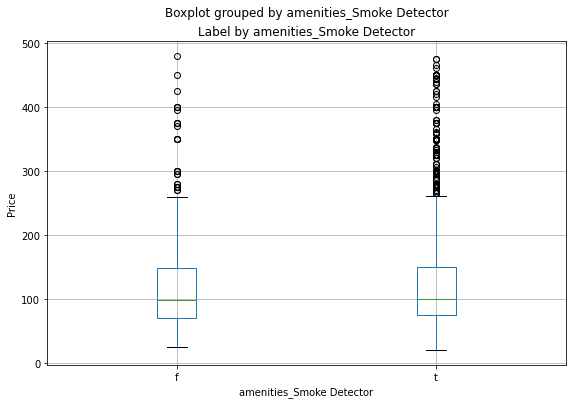

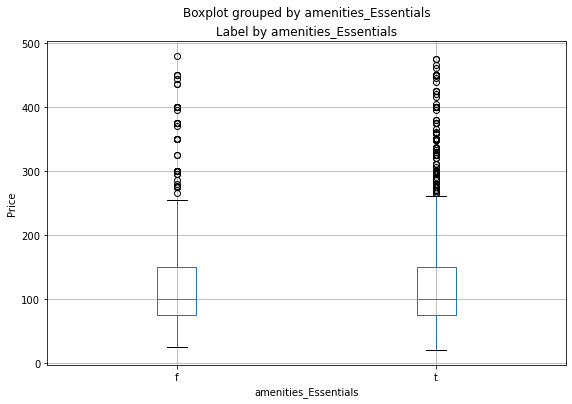

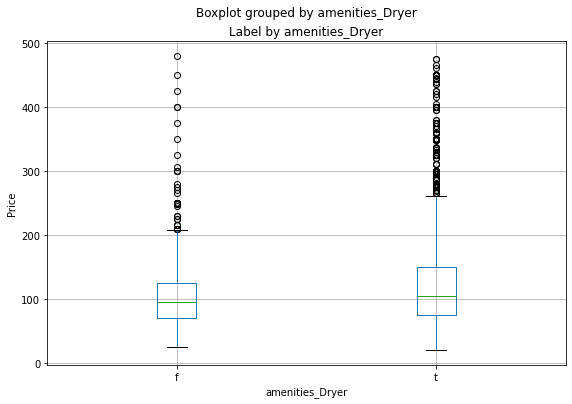

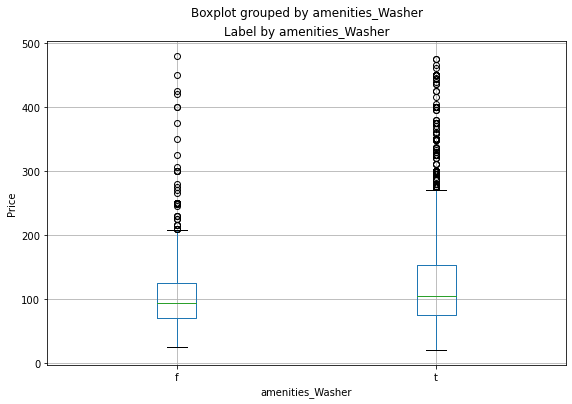

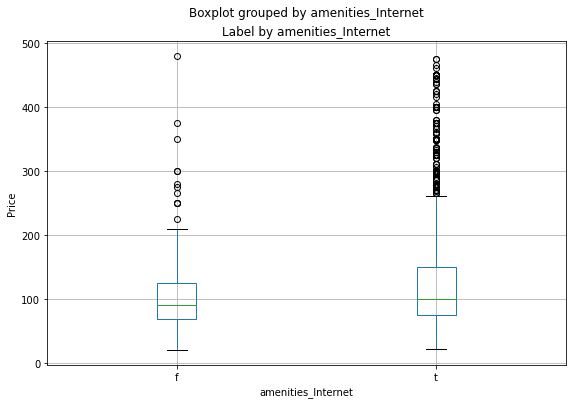

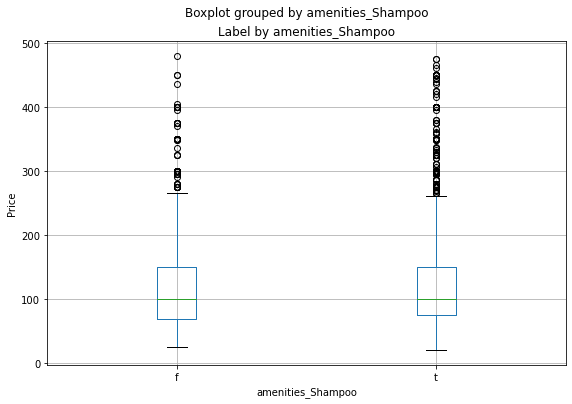

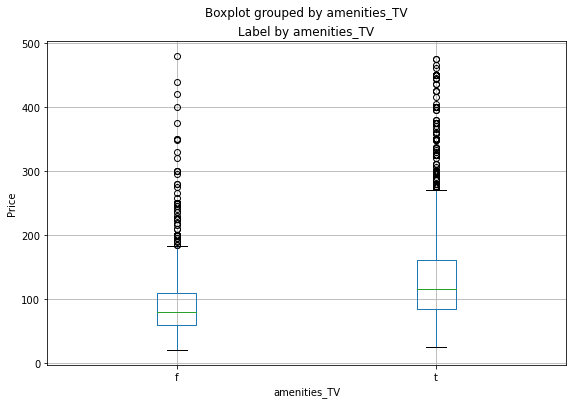

In [20]:
# View plots of categorical features compared to price

for col in df_categorical_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df_listings.boxplot(column = 'price', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("Price")
plt.show()

Looking at the above plots, the columns I would like to keep in my model are:

In [21]:
# Categorical values to keep
categorical = ['neighbourhood_group_cleansed', 'cancellation_policy', 'require_guest_profile_picture', 
              'property_type', 'room_type', 'bed_type', 'amenities_Wireless Internet',
               'amenities_Kitchen', 'amenities_Internet', 'amenities_TV' , 'amenities_Washer', 'amenities_Dryer']

# Step 5: Modelling

My final dataset for training a model will be a combination of numerical and categorical features

In [22]:
df = df_listings[numerical + categorical]
df.head()

,accommodates,bedrooms,beds,price,neighbourhood_group_cleansed,cancellation_policy,require_guest_profile_picture,property_type,room_type,bed_type,amenities_Wireless Internet,amenities_Kitchen,amenities_Internet,amenities_TV,amenities_Washer,amenities_Dryer
0,4,1.0,1.0,85.0,Queen Anne,moderate,f,Apartment,Entire home/apt,Real Bed,t,t,t,t,t,t
1,4,1.0,1.0,150.0,Queen Anne,strict,t,Apartment,Entire home/apt,Real Bed,t,t,t,t,t,t
3,3,0.0,2.0,100.0,Queen Anne,flexible,f,Apartment,Entire home/apt,Real Bed,t,t,t,f,t,t
4,6,3.0,3.0,450.0,Queen Anne,strict,f,House,Entire home/apt,Real Bed,t,t,t,t,f,f
5,2,1.0,1.0,120.0,Queen Anne,strict,f,House,Private room,Real Bed,t,f,t,f,f,f


First I need to dummy my categorical variables

In [23]:
def create_dummy_df(df, cat_cols, dummy_na):
    
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [24]:
df = create_dummy_df(df, categorical, dummy_na=False)
df.head()

,accommodates,bedrooms,beds,price,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,...,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,amenities_Wireless Internet_t,amenities_Kitchen_t,amenities_Internet_t,amenities_TV_t,amenities_Washer_t,amenities_Dryer_t
0,4,1.0,1.0,85.0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
1,4,1.0,1.0,150.0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
3,3,0.0,2.0,100.0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,1
4,6,3.0,3.0,450.0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,0,0
5,2,1.0,1.0,120.0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0


For my numeric features, I need to ensure there are no missing values. I will use the mean filling method for this:

In [25]:
#Input missing features

fill_mean = lambda col: col.fillna(col.mean())
df = df.apply(fill_mean, axis = 0)

check_missing_values(df)

'No columns with missing values'

Now I can set my X and y for the model

In [26]:
X = df.drop(columns = 'price')
y = df_listings['price']

In [27]:
#Train and evaluate the model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for this model is {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))


/Users/kirsten.young/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


'The r-squared score for this model is 0.5893373347328845 on 1135 values.'

# Step 6: Visualise

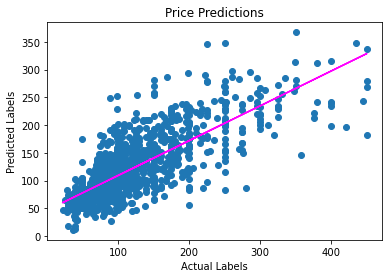

In [28]:
#Plot predicted labels vs. actual labels 

plt.scatter(y_test,y_test_preds)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Price Predictions')
# overlay the regression line
z = np.polyfit(y_test, y_test_preds, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

The r-squared score is around 0.59 - this means that 59% of the variation in price can be explained by the numerical and cateogrical features we included in the model. It's not perfect, but it could still be used as a tool in coming up with a price for your listing. 

I want to determine which of my features are the best indicators for price. Determining the coefficients will be an indication of the impact of each variable on the price of a listing. The larger the coefficient, the larger the expected impact on price.

In [29]:
#Create function to deterine top indicators for price
def coef_weights(coefficients, X_train):
    
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [30]:
coef_df = coef_weights(lm_model.coef_, X_train)
coef_df.head(10)

,est_int,coefs,abs_coefs
29,property_type_Dorm,-93.455167,93.455167
38,room_type_Shared room,-64.123785,64.123785
23,property_type_Boat,56.699583,56.699583
26,property_type_Camper/RV,50.471908,50.471908
22,property_type_Bed & Breakfast,43.164723,43.164723
37,room_type_Private room,-35.880634,35.880634
1,bedrooms,35.347610,35.347610
31,property_type_Loft,34.663698,34.663698
8,neighbourhood_group_cleansed_Downtown,32.593120,32.593120
14,neighbourhood_group_cleansed_Queen Anne,25.626908,25.626908


/var/folders/67/jgz6df654fv9n3yp6bkjl9f8ry5zws/T/ipykernel_10964/1110632087.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(coef_df['est_int'].head(10), rotation=45)


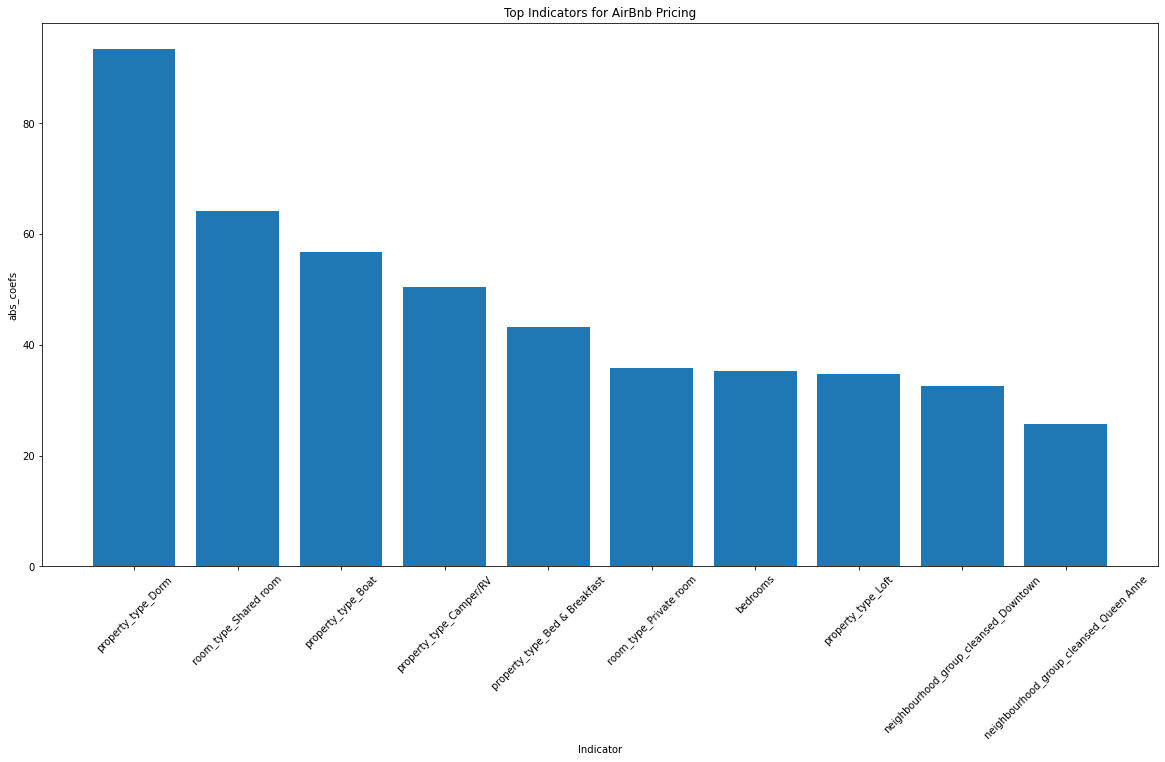

In [31]:
#Plot coefficients 

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)

plt.bar(coef_df['est_int'].head(10),coef_df['abs_coefs'].head(10))
plt.xlabel('Indicator')
ax.set_xticklabels(coef_df['est_int'].head(10), rotation=45)
plt.ylabel('abs_coefs')
plt.title('Top Indicators for AirBnb Pricing')
plt.show()

It looks like the variables with the biggest impact on price are the property type, room type, number of bedrooms and neighbourhood. 

Now lets see if we can actually use the model to predict prices

In [32]:
# Save the model
filename = './lm_model.pkl'
joblib.dump(lm_model, filename)

['./lm_model.pkl']

In [33]:
#Import listings scenarios.csv 
X_new = pd.read_csv('./MyHouse.csv').reset_index(drop=True)
Scenario = ['3 bed house Interbay', 'Party Bungalow Cascade', 'Business trip loft Beacon Hill']
X_new.head()

,accommodates,bedrooms,beds,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,...,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,amenities_Wireless Internet_t,amenities_Kitchen_t,amenities_Internet_t,amenities_TV_t,amenities_Washer_t,amenities_Dryer_t
0,4,3,3,0,0,0,0,0,0,1,...,0,0,0,1,1,1,1,1,1,1
1,8,4,4,0,0,1,0,0,0,0,...,0,0,0,1,1,0,1,1,0,0
2,1,1,1,1,0,1,0,0,0,0,...,0,0,0,1,1,1,1,0,0,0


In [34]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Use the model to predict price
result = loaded_model.predict(X_new)
result

array([169.41337975, 267.48431395,  99.94041695])

/var/folders/67/jgz6df654fv9n3yp6bkjl9f8ry5zws/T/ipykernel_10964/1655629384.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(Scenario, rotation=45)


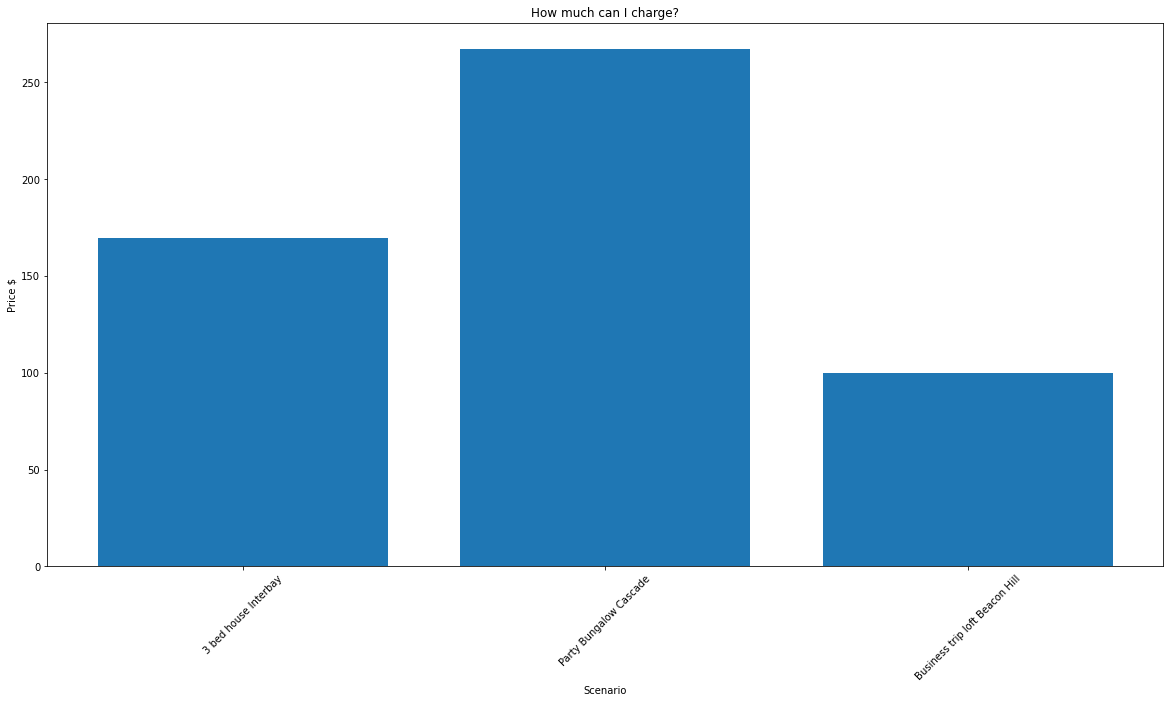

In [35]:
#Plot coefficients 

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)

plt.bar(Scenario, result)
plt.xlabel('Scenario')
ax.set_xticklabels(Scenario, rotation=45)
plt.ylabel('Price $')
plt.title('How much can I charge?')
plt.show()

I have used the model to predict prices for 3 scenarios. The model could be applied to other senarios too to assist with price determination. 